In [1]:
import torch
import torch.nn as nn
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter
from pytorch_transformers import AdamW, WarmupLinearSchedule, WarmupConstantSchedule
import torch.nn.functional as F
import random
import time
import os
import cv2
from PIL import Image
from tqdm import tqdm
img_path=r'D:\Python\Python_Project\NJU\Single Modality\data\MVSA\MVSA_Single\data'

In [2]:
def crop_centre(img,new_width,new_height):
    height,width,_=img.shape
    startx=width//2-new_width//2
    starty=height//2-new_height//2
    return img[starty:starty+new_height,startx:startx+new_width, :]

In [3]:
'''
Since the images vary in size, you first need to resize the images to the same size
'''
def image_processing(img_path):
    for dir_image in tqdm(os.listdir(img_path)):
        if dir_image[-3:]=='jpg':
            img_p=Image.open(os.path.join(img_path,dir_image))
            img_size=img_p.resize((256,256))
            img_size.save(fr'D:\Python\Python_Project\NJU\Single Modality\data\MVSA\MVSA_Single\img_resize\{dir_image}','JPEG')

image_processing(img_path)

100%|██████████| 9738/9738 [00:50<00:00, 191.75it/s]


In [4]:
img_processed=r'D:\Python\Python_Project\NJU\Single Modality\data\MVSA\MVSA_Single\img_resize'
def save_image_h5(img_path=img_path):
    img_list=[]
    for dir_image in tqdm(os.listdir(img_path)):
        if dir_image[-3:]=='jpg':
            img=cv2.imread(os.path.join(img_path,dir_image))
            img=crop_centre(img,256,256)
            img_list.append(img)

    img_np = np.array(img_list)
    with h5py.File(r'D:\Python\Python_Project\NJU\Single Modality\data\MVSA\MVSA_Single\image.h5','w') as f:
        f.create_dataset('img_data',data = img_np)
        f.close()
    print('Save Successfully...')
save_image_h5(img_path=img_processed)

100%|██████████| 4869/4869 [00:05<00:00, 917.34it/s]


Save Successfully...


In [2]:
def normalize(image):
    mean = np.mean(image)
    var = np.mean(np.square(image-mean))
    image = (image - mean)/np.sqrt(var)
    return image
class ImgDataset(Dataset):
    def __init__(self,h5_path,csv_name='Label.csv'):

        self.file_object=h5py.File(h5_path,'r')
        self.dataset=self.file_object['img_data']
        self.label_df=pd.read_csv(csv_name)
        pass
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, item):
        if(item>len(self.dataset)):
            raise IndexError()
        img_value=torch.FloatTensor(np.array(self.dataset[int(item)]/255.0))
        img_label=torch.LongTensor([self.label_df['image_label'][item]])
        return img_value,img_label
    def plot_image(self,index):
        arr=np.array((self.dataset[int(index)])/255.0)
        plt.imshow(arr,interpolation='nearest')
        plt.show()
#The role of View is to tile the (218,178,3) three-dimensional tensor into a one-dimensional tensor 218*178*3
batchsize=16
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [4]:
imgdataset=ImgDataset(h5_path=r'D:\Python\Python_Project\NJU\Single Modality\data\MVSA\MVSA_Single\image.h5')

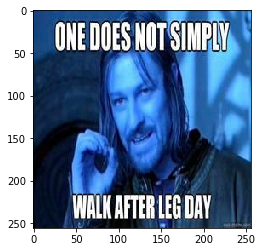

In [5]:
imgdataset.plot_image(0)
# 

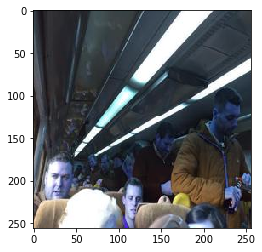

In [6]:
imgdataset.plot_image(1)

In [7]:
data_loader=DataLoader(imgdataset,batch_size=batchsize,shuffle=True)
for img,label in data_loader:
    #x[ batch_size, channels, height_1, width_1 ]
    print(img.transpose(1,3).shape)
    print(label)
    break

torch.Size([16, 3, 256, 256])
tensor([[0],
        [2],
        [1],
        [2],
        [2],
        [2],
        [0],
        [2],
        [1],
        [0],
        [2],
        [0],
        [2],
        [0],
        [0],
        [0]])


In [8]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        #Conv2d[ channels, output, height_2, width_2 ]
        self.layer1=nn.Sequential(nn.Conv2d(3,256,kernel_size=5,stride=2),
                                    #Feature map size 225x225
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(0.02))
        self.layer2=nn.Sequential(nn.Conv2d(256,64,kernel_size=4,stride=2),
                                    #Feature map size 81x81
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(0.02))
        self.layer3=nn.Sequential(nn.Conv2d(64,3,kernel_size=3,stride=2),
                                    #Feature map size 9x9
                                    nn.LeakyReLU(0.2))
        self.dp=nn.Dropout(0.5)
        self.fc=nn.Linear(3*30*30,3)

    def forward(self,inputs):
        conv1=self.layer1(inputs)
        print(conv1.shape)
        conv2=self.layer2(conv1)
        print(conv2.shape)
        conv3=self.layer3(conv2)
        print(conv3.shape)
        dp=self.dp(conv3)

        dp=dp.view(dp.shape[0],-1)
        pred=self.fc(dp)
        pred = F.log_softmax(pred, dim=1)
        print(pred.shape)
        return pred

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [9]:
#parameter:
DEVICE='cuda'
LR=0.01
N_EPOCH=30
model=Classifier().to(DEVICE)

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)
scheduler=WarmupConstantSchedule(optimizer=optimizer,warmup_steps=1000)
lossfunction=nn.CrossEntropyLoss()
writer=SummaryWriter()
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [10]:
%time
for i in range(N_EPOCH):
    each_loss=0
    acc=0
    start_time=time.time()
    for img,label in tqdm(data_loader):
        optimizer.zero_grad()
        img=img.transpose(1,3).to(DEVICE)
        # print(img.shape)
        label=label.reshape(-1).to(DEVICE)
        outputs=model(img)


        loss=lossfunction(outputs,label)
        loss.backward()
        optimizer.step()
        scheduler.step()
        acc=acc+categorical_accuracy(outputs,label)
        each_loss=each_loss+loss.item()
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    writer.add_scalar('Train/Loss',each_loss/len(data_loader),i)
    writer.add_scalar('Train/Accuracy',acc/len(data_loader),i)
    torch.save(model.state_dict(), str(i)+'CNN-model.pt')
    print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {each_loss/len(data_loader):.3f} | Train Acc: {acc*100/len(data_loader):.2f}%')

Wall time: 0 ns


  0%|          | 0/305 [00:00<?, ?it/s]

torch.Size([16, 256, 126, 126])
torch.Size([16, 64, 62, 62])
torch.Size([16, 3, 30, 30])
torch.Size([16, 3])


  0%|          | 0/305 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 250.00 MiB (GPU 0; 2.00 GiB total capacity; 785.35 MiB already allocated; 249.35 MiB free; 792.00 MiB reserved in total by PyTorch)